In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Kuliah/Pengolahan Citra Digital/Capstone Project - Stress Emotion

/content/drive/MyDrive/Kuliah/Pengolahan Citra Digital/Capstone Project - Stress Emotion


In [4]:
train_dir = "Dataset/train/" #passing the path with training images
test_dir = "Dataset/test/"   #passing the path with testing images

In [5]:
def jumlah(path, set_):
    dict_ = {}
    for tingkatan in os.listdir(path):
        dir_ = path + tingkatan
        dict_[tingkatan] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

print(jumlah(train_dir, 'train'))
print(jumlah(test_dir, 'test'))

       disgust  angry  sad  neutral  fear  happy
train      500    500  500      500   500    510
      happy  neutral  disgust  sad  fear  angry
test    160      150      111  160   150    150


In [6]:
img_size = 48 #original size of the image

(48, 48, 3)
(1, 48, 48, 3)


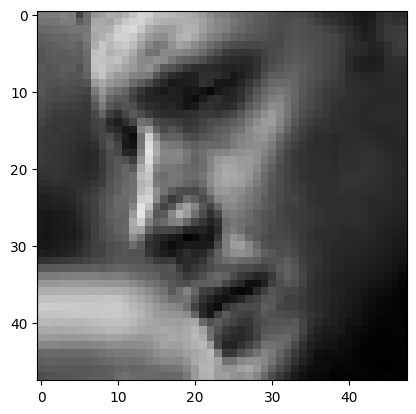

In [7]:
from keras.preprocessing import image
img = image.load_img("Dataset/test/angry/PrivateTest_1054527.jpg",target_size=(48,48))
img = np.array(img)
plt.imshow(img)
print(img.shape)

img = np.expand_dims(img, axis=0)
from keras.models import load_model
print(img.shape)


# Data Augmentation


In [8]:
#train_datagen/validation_datagen = variable
#ImageDataGenerator = fungsi

train_datagen = ImageDataGenerator(     width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                        featurewise_center = False,
                                         zoom_range = 0.2,
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,)

In [11]:
"""
Applying data augmentation to the images as we read
them from their respectivve directories
"""
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    class_mode = "categorical",
                                                    shuffle = True
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              shuffle = True,
                                                              class_mode= "categorical"

                                                             )

Found 3010 images belonging to 6 classes.
Found 881 images belonging to 6 classes.


In [12]:
base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights="imagenet")
base_model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 54, 54, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 24, 24, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 24, 24, 64)           256       ['conv1_conv[0][0]']          
 on)                      

In [15]:
for layer in base_model.layers:
    layer.trainable=True

In [16]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(6,activation='softmax'))

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout_2 (Dropout)         (None, 2, 2, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_2 (Bat  (None, 8192)              32768     
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 64)                524352    
                                                                 
 batch_normalization_3 (Bat  (None, 64)                256       
 chNormalization)                                     

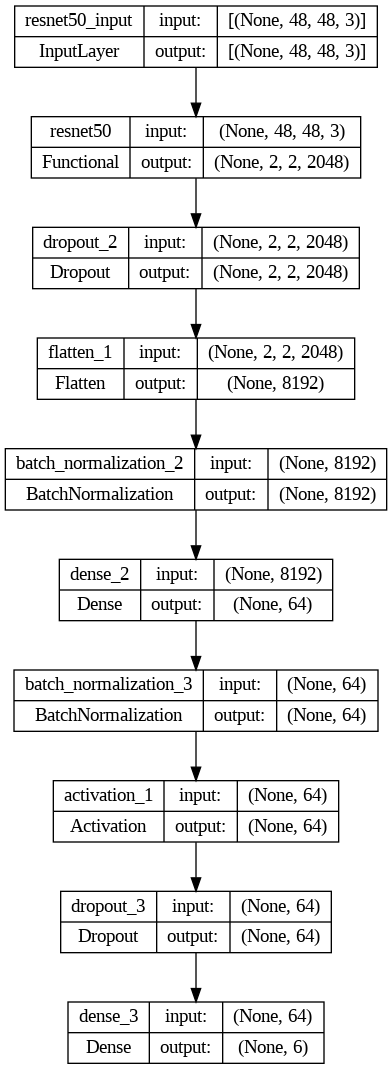

In [18]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [19]:
import keras.backend as K
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [20]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [21]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [22]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
history=model.fit(train_generator,validation_data=validation_generator,epochs = 60,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/60


In [ ]:
fig , ax = plt.subplots(1,2)

train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
model.save('model_optimal.h5')